# New Measure - Proprotion of MDI from All Inhalers

## Rationale


The NHS 10 year plan comits the NHS to reduce harmful enviromental emissions. One way of doing this is to shift from Metered Dose Inhalers (MDI) to Dry Powdered Inhalers (DPI). This notebook is a prototype for modelling the current prescribing patterns in England.

## Proposed Measure

### Title
Proprotion of MDIs prescribed as a total of all inhalers

### Description
Proprotion of MDIs prescribed as a total of all inhalers from the respiratory chapter in the BNF

### Why it matters
The NHS has comitted to reducing enviromental emissions by x% by 20xx. An estimated x% of emissions come from inhalers. Dry pwoder inhalers (DPIs) are less harmful to the enviroment than traditional metered dose inhalers (MDIs) and the NHS long term plan supports the use of DPI where it is clinically appropriate. NICE have produced an [inhaler decision aid](https://www.nice.org.uk/guidance/ng80/resources/inhalers-for-asthma-patient-decision-aid-pdf-6727144573) to faciltiate decisons about inhalers
You can read more about this measure on our blog [here](https://docs.google.com/document/d/1OQeuHV0AKB8VG87DUcUSjaj7Dre3jKJ7oIjRokaS-uI/edit)

## Numerators & Denominators
They can be viewed here on this [google sheet](https://docs.google.com/spreadsheets/d/1aZGJkN-HF0PrYqmWpIdr72J9sVZGpLm2b1-T-ooje3g/edit#gid=0) Correct as of prescribing data May 2019.  At OpenPrescribing we use live automated code and this should always be consulted as the current reference. Branded Inhalers or BNF codes released prior to x 2019 will not be included on this spreadsheet.

## SQL and Mock up

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps
import matplotlib.gridspec as gridspec

In [2]:
## Here we query our prescribing file to create a dataframe of all inhaler prescribing
sql = '''
SELECT
  presc.month,
  pct,
  pract.name,
  presc.practice,
  SUM(
  IF
    (form_route='powderinhalation.inhalation',
      ##from dmd, identifies a DPI
      items,
      0)) AS dpi,
  SUM(
  IF
    (form_route='pressurizedinhalation.inhalation',
      ##from dmd, identifies a MDI
      items,
      0)) AS mdi,
  SUM(items) AS totalinhalers
FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc
LEFT JOIN
  ebmdatalab.hscic.practices AS pract
ON
  presc.practice=pract.code
LEFT JOIN
  # is this join in the right place  review
  ebmdatalab.hscic.practice_statistics_all_years AS stat
ON
  presc.practice = stat.practice
  AND presc.month = stat.month
LEFT JOIN
  ebmdatalab.dmd.form_dose AS dmd
ON
  presc.bnf_code=dmd.bnf_code
WHERE
  presc.bnf_code LIKE "030%"
  AND (form_route="powderinhalation.inhalation"
    OR form_route= "pressurizedinhalation.inhalation")
    AND setting = 4 
    AND pct != "112"
GROUP BY
  month,
  pct,
  name,
  practice
  '''

df1 = bq.cached_read(sql, csv_path='df1.csv', use_cache=True)
df1['month'] = pd.to_datetime(df1['month'])
df1.head(5)

,month,pct,name,practice,dpi,mdi,totalinhalers
0,2015-08-01,04D,CASKGATE STREET SURGERY,C83044,624,608,1232
1,2015-08-01,00T,SWAN LANE MEDICAL CENTRE,P82004,202,485,687
2,2015-08-01,03R,DR SP SINGH AND PARTNERS,B87006,621,1431,2052
3,2015-08-01,00C,CARMEL MEDICAL PRACTICE,A83031,355,459,814
4,2015-08-01,02G,COUNTY ROAD SURGERY,P81727,94,136,230


In [3]:
##here we print a csv file of numerator and denominators so interested users can consult a google sheet with the list
sql = '''
SELECT DISTINCT
  bnf_name,
  presc.bnf_code,
  form_route
FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc
JOIN
  ebmdatalab.dmd.form_dose AS dmd
ON
  presc.bnf_code=dmd.bnf_code
WHERE
  presc.bnf_code LIKE "030%"
  AND (form_route="powderinhalation.inhalation"
    OR form_route= "pressurizedinhalation.inhalation")
GROUP BY
  bnf_name,
  presc.bnf_code,
  form_route
  '''

df2 = bq.cached_read(sql, csv_path='df2_num_denom.csv', use_cache=True)
df2.nunique()

bnf_name      486
bnf_code      321
form_route      2
dtype: int64

## ^ WHY IS IT DUPLICATING SOME BUT NOT ALL?

I think it is a whitespace issue on the name. Is this correct? What is the best way to fix it?

In [4]:
df1["measure_value"] = (df1["mdi"] / df1["totalinhalers"])*100
df1.head()

,month,pct,name,practice,dpi,mdi,totalinhalers,measure_value
0,2015-08-01,04D,CASKGATE STREET SURGERY,C83044,624,608,1232,49.350649
1,2015-08-01,00T,SWAN LANE MEDICAL CENTRE,P82004,202,485,687,70.596798
2,2015-08-01,03R,DR SP SINGH AND PARTNERS,B87006,621,1431,2052,69.736842
3,2015-08-01,00C,CARMEL MEDICAL PRACTICE,A83031,355,459,814,56.388206
4,2015-08-01,02G,COUNTY ROAD SURGERY,P81727,94,136,230,59.130435


In [5]:
df1_2019 = df1.loc[df1['month'] >= "2019-04-01"]
df1_2019.head()

,month,pct,name,practice,dpi,mdi,totalinhalers,measure_value
139325,2019-04-01,00N,THE GLEN MEDICAL GROUP,A88022,361,1030,1391,74.047448
139326,2019-04-01,08R,THE MITCHAM MEDICAL CENTRE.,H85024,183,373,556,67.086331
139327,2019-04-01,04F,WHADDON MEDICAL CENTRE,K82026,307,981,1288,76.164596
139328,2019-04-01,10V,THE STAUNTON SURGERY,J82041,411,746,1157,64.477096
139329,2019-04-01,00Q,DR DC MATHUR & PTNR,P81204,213,523,736,71.059783


In [6]:
df1_2019["measure_value"] = (df1_2019["mdi"] / df1_2019["totalinhalers"])*100
df1_2019.head(5)

C:\Users\bmackenna\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,month,pct,name,practice,dpi,mdi,totalinhalers,measure_value
139325,2019-04-01,00N,THE GLEN MEDICAL GROUP,A88022,361,1030,1391,74.047448
139326,2019-04-01,08R,THE MITCHAM MEDICAL CENTRE.,H85024,183,373,556,67.086331
139327,2019-04-01,04F,WHADDON MEDICAL CENTRE,K82026,307,981,1288,76.164596
139328,2019-04-01,10V,THE STAUNTON SURGERY,J82041,411,746,1157,64.477096
139329,2019-04-01,00Q,DR DC MATHUR & PTNR,P81204,213,523,736,71.059783


In [7]:
by_pct_df1 = df1.groupby(['pct', 'month'], as_index=False).sum()
by_pct_df1.head()

,pct,month,dpi,mdi,totalinhalers,measure_value
0,00C,2010-08-01,2852,5367,8219,808.385564
1,00C,2010-09-01,3071,5864,8935,802.380833
2,00C,2010-10-01,2888,5719,8607,825.627451
3,00C,2010-11-01,3070,5897,8967,811.343437
4,00C,2010-12-01,3524,6557,10081,806.247535


In [8]:
by_pct_df1["measure_value"] = (by_pct_df1["mdi"] / by_pct_df1["totalinhalers"])*100

In [9]:
by_pct_df1_2019 = df1[df1['month'] >= "2019-04-01"].groupby('pct').sum().reset_index()
by_pct_df1_2019.head()

,pct,dpi,mdi,totalinhalers,measure_value
0,00C,9603,13935,23538,1310.562740
1,00D,35138,56508,91646,4566.889079
2,00J,23469,37365,60834,3697.991432
3,00K,28581,50974,79555,4221.386253
4,00L,37358,42109,79467,4493.083974


In [10]:
by_pct_df1_2019["measure_value"] = (by_pct_df1_2019["mdi"] / by_pct_df1_2019["totalinhalers"])*100

## Deciles

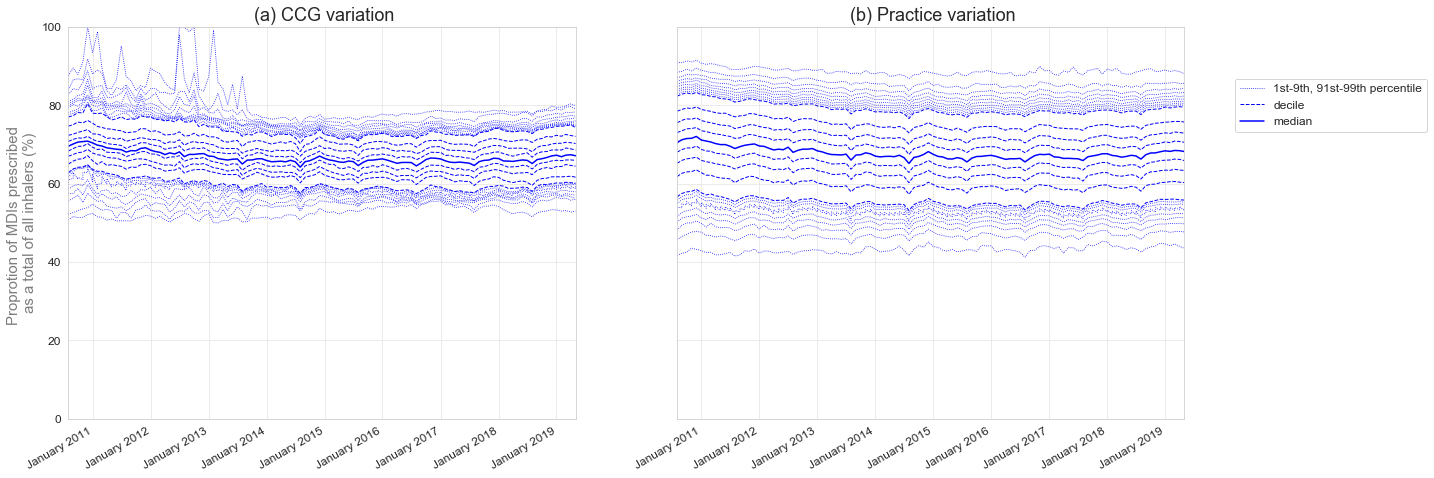

In [14]:
f = plt.figure(figsize=(20,8))
#f.suptitle('Sharing Y axis')
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 

# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)

charts.deciles_chart(
    by_pct_df1,
    period_column='month',
    column='measure_value',
    title=" (a) CCG variation",
    ylabel="Proprotion of MDIs prescribed \n as a total of all inhalers (%) ",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot, 
) 


charts.deciles_chart(
    df1,
    period_column='month',
    column='measure_value',
    title=" (b) Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=right_plot,
) 

plt.ylim(0, 100)
plt.show()

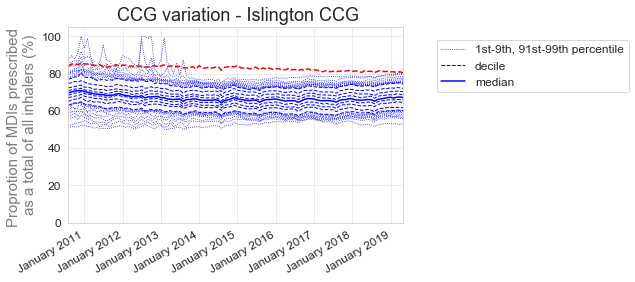

In [12]:
###here we chart a ccg example
charts.deciles_chart(
    by_pct_df1,
    period_column='month',
    column='measure_value',
    title=" CCG variation - Islington CCG",
    ylabel="Proprotion of MDIs prescribed \n as a total of all inhalers (%) ",
    show_outer_percentiles=True,
    show_legend=True 
) 


#add in example CCG (Islington - 08h)
df_subject = by_pct_df1.loc[by_pct_df1['pct'] == '08H']
plt.plot(df_subject['month'], df_subject['measure_value'], 'r--')
plt.show()

## Maps - Geographic Variation

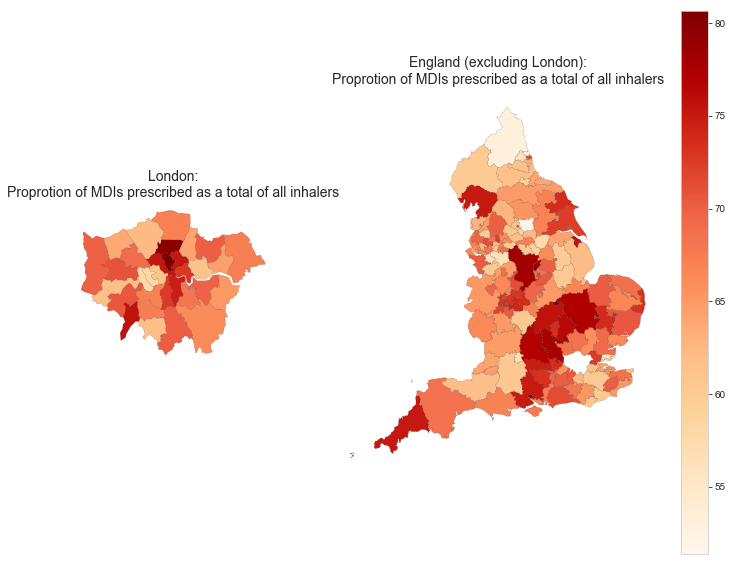

In [13]:
plt.figure(figsize=(12,10))
plt = maps.ccg_map(by_pct_df1_2019, title="Proprotion of MDIs prescribed as a total of all inhalers", column='measure_value', cartogram=False, separate_london=True)
plt.show()